In [15]:
import os
import sys
import time

import numpy as np
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score

## Cortar Imagenes


In [2]:
import cv2
from skimage.transform import resize

def recortar_centro(images, nuevo_tamano=(21, 21)):
    """Recorta el centro de las imágenes"""
    h, w = images.shape[1:3]
    nuevo_h, nuevo_w = nuevo_tamano
    
    # Calcular coordenadas para recorte central
    start_h = (h - nuevo_h) // 2
    start_w = (w - nuevo_w) // 2
    
    # Recortar
    images_recortadas = images[:, start_h:start_h+nuevo_h, start_w:start_w+nuevo_w, :]
    return images_recortadas


In [3]:
def procesar_datos_astronomia(data_dict):
    """
    Versión específica para el dataset astronómico descrito
    """
    
    resultado = {}
    
    for conjunto in ['Train', 'Validation', 'Test']:
        if conjunto in data_dict:
            print(f"Procesando {conjunto}...")
            
            datos = data_dict[conjunto]
            imagenes = datos['images']
            etiquetas = datos['labels']
            caracteristicas = datos['features']
            
            # 1. Reemplazar NaN por 0
            imagenes = np.nan_to_num(imagenes, nan=0.0)
            
            # 2. Recortar al centro a 21x21 píxeles
            if imagenes.shape[1] > 21:
                inicio = (imagenes.shape[1] - 21) // 2
                imagenes = imagenes[:, inicio:inicio+21, inicio:inicio+21, :]
            
            # 3. Normalizar cada imagen individualmente entre 0-1
            imagenes_normalizadas = np.zeros_like(imagenes)
            
            for i in range(imagenes.shape[0]):
                for canal in range(imagenes.shape[3]):
                    canal_img = imagenes[i, :, :, canal]
                    minimo = np.min(canal_img)
                    maximo = np.max(canal_img)
                    
                    if maximo > minimo:
                        canal_norm = (canal_img - minimo) / (maximo - minimo)
                    else:
                        canal_norm = np.zeros_like(canal_img)
                    
                    imagenes_normalizadas[i, :, :, canal] = canal_norm
            
            resultado[conjunto] = {
                'images': imagenes_normalizadas.astype(np.float32),
                'labels': etiquetas,
                'features': caracteristicas
            }
            
            # Verificación
            img = resultado[conjunto]['images'][0]
            print(f"  Forma: {img.shape}, Rango: [{np.min(img):.3f}, {np.max(img):.3f}]")
    
    return resultado


## Crear clase para los datasets

In [4]:
class CustomImageDataset_1(Dataset):
    def __init__(self, data_dict, transform=None):
        """
        data_dict: diccionario con keys 'images', 'features', 'labels'
        transform: transformaciones a aplicar (como en tu notebook)
        """
        self.images = data_dict['images']
        self.labels = data_dict['labels']
        self.features = data_dict.get('features', None)  # Opcional, si quieres usar features
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        features = self.features[idx] if self.features is not None else None

        if self.transform:
            image = self.transform(image)

        if features is not None:
            # Si es numpy array, conviértelo a float32 y tensor
            if isinstance(features, np.ndarray):
                features = features.astype(np.float32)
                features = torch.from_numpy(features)
            elif not torch.is_tensor(features):
                features = torch.tensor(features, dtype=torch.float32)
            return image, label, features
        else:
            return image, label
            

In [5]:
class CustomImageDataset_2(Dataset):
    def __init__(self, data_dict, transform=None):
        """
        data_dict: diccionario con keys 'images', 'features', 'labels'
        transform: transformaciones a aplicar (como en tu notebook)
        """
        self.images = data_dict['images']
        self.labels = data_dict['labels']
        self.features = data_dict.get('features', None)  # Opcional, si quieres usar features
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Aplicar transformaciones si están definidas
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Cargar datasets

In [6]:
# Cargar y procesar datos
data = pd.read_pickle('stamps.pkl')
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Aplicar a todos los conjuntos
train = data["Train"]
val = data["Validation"]
test = data["Test"]

train['images'] = recortar_centro(train['images'])
val['images'] = recortar_centro(val['images'])
test['images'] = recortar_centro(test['images'])
# Crea los datasets
train_dataset_1 = CustomImageDataset_1(train, transform=transform)
val_dataset_1 = CustomImageDataset_1(val, transform=transform)
test_dataset_1 = CustomImageDataset_1(test, transform=transform)

train_dataset_2 = CustomImageDataset_2(train, transform=transform)
val_dataset_2 = CustomImageDataset_2(val, transform=transform)
test_dataset_2 = CustomImageDataset_2(test, transform=transform)

## Modelos CNN con rotación y sin rotación

In [17]:
class CNNModel_WR(nn.Module):
    def __init__(self, dropout_p=0.5, num_classes=5):
        super().__init__()
        self.fc2 = nn.Linear(90, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=dropout_p)  # Dropout separado
        # Zero padding layer (21x21 -> 27x27)
        self.zero_pad = nn.ZeroPad2d(3)  # 3 pixels on each side: 21+6=27
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolution: 4x4, 32 filters
            # Input: 27x27, Output: 24x24 (27-4+1=24)
            nn.Conv2d(3, 32, kernel_size=4),
            nn.ReLU(),
            
            # Second convolution: 3x3, 32 filters
            # Input: 24x24, Output: 24x24 (with padding=1)
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Max pooling: 2x2, stride 2
            # Input: 24x24, Output: 12x12 (24/2=12)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolution: 3x3, 64 filters
            # Input: 12x12, Output: 12x12 (with padding=1)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Fourth convolution: 3x3, 64 filters
            # Input: 12x12, Output: 12x12 (with padding=1)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Fifth convolution: 3x3, 64 filters
            # Input: 12x12, Output: 12x12 (with padding=1)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Max pooling: 2x2, stride 2
            # Input: 12x12, Output: 6x6 (12/2=6)
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Flatten and first fully connected layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2304, 64)  # 6x6x64 = 2304
        
        # Batch normalization
        self.bn = nn.BatchNorm1d(64)
        
        # Final fully connected layers
        self.final_layers = nn.Sequential(
            # Input: 64 + 26 = 90 features after concatenation
            nn.Linear(90, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def rotation_augmentation(self, x):
        """
        Apply rotation augmentation (0째, 90째, 180째, 270째)
        Input: (batch_size, 3, 27, 27)
        Output: (batch_size, 4, 3, 27, 27) - 4 rotated versions
        """
        batch_size = x.shape[0]
        rotations = []
        
        # Apply 4 rotations
        for k in range(4):
            rotated = torch.rot90(x, k, dims=[2, 3])  # Rotate height and width dimensions
            rotations.append(rotated)
        
        # Stack along new dimension: (batch_size, 4, 3, 27, 27)
        return torch.stack(rotations, dim=1)

    def rotation_concatenation(self, features):
        """
        Concatenate features from rotated versions
        Input: (batch_size, 4, 64) - features from 4 rotations
        Output: (batch_size, 4, 64) - same shape for cyclic pooling
        """
        # Already in the right shape from rotation_augmentation processing
        return features

    def cyclic_pooling(self, features):
        """
        Apply cyclic pooling across rotation dimension
        Input: (batch_size, 4, 64)
        Output: (batch_size, 64) - pooled features
        """
        # Use max pooling across rotation dimension
        pooled, _ = torch.max(features, dim=1)
        return pooled

    def forward(self, x, bn_features=None):
        """
        Forward pass
        x: input images (batch_size, 21, 21, 3) or (batch_size, 3, 21, 21)
        bn_features: batch normalization features to concatenate (batch_size, 23)
        """
        # Ensure correct input shape: (batch_size, 3, 21, 21)
        if len(x.shape) == 4 and x.shape[1] != 3:
            x = x.permute(0, 3, 1, 2)  # (batch_size, 21, 21, 3) -> (batch_size, 3, 21, 21)
        
        # Zero padding: 21x21 -> 27x27
        x = self.zero_pad(x)  # (batch_size, 3, 27, 27)
        
        # Rotation augmentation
        x_rotated = self.rotation_augmentation(x)  # (batch_size, 4, 3, 27, 27)
        batch_size, num_rotations = x_rotated.shape[0], x_rotated.shape[1]
        
        # Process each rotation through conv layers
        rotation_features = []
        for i in range(num_rotations):
            # Get one rotation: (batch_size, 3, 27, 27)
            rot_img = x_rotated[:, i, :, :, :]
            
            # Convolutional layers
            conv_out = self.conv_layers(rot_img)  # (batch_size, 64, 6, 6)
            
            # Flatten and fully connected
            flat_out = self.flatten(conv_out)  # (batch_size, 2304)
            fc_out = self.fc1(flat_out)  # (batch_size, 64)
            
            rotation_features.append(fc_out)
        
        # Stack rotation features: (batch_size, 4, 64)
        rotation_features = torch.stack(rotation_features, dim=1)
        
        # Rotation concatenation
        concat_features = self.rotation_concatenation(rotation_features)  # (batch_size, 4, 64)
        
        # Cyclic pooling
        pooled_features = self.cyclic_pooling(concat_features)  # (batch_size, 64)
        
        # Batch normalization
        bn_out = self.bn(pooled_features)  # (batch_size, 64)
        
        # Concatenate with BN features (23 features)
        if bn_features is not None:
            combined_features = torch.cat([bn_out, bn_features], dim=1)  # (batch_size, 64 + 26)
        else:
            # If no BN features provided, use zeros
            bn_features = torch.zeros(batch_size, 26).to(x.device)
            combined_features = torch.cat([bn_out, bn_features], dim=1)  # (batch_size, 87)
        
        # Final classification layers CON CONTROL DE DROPOUT
        x = torch.relu(self.fc2(combined_features))
        
        # Aplicar dropout solo durante entrenamiento
        if self.training:
            x = self.dropout(x)
        
        x = torch.relu(self.fc3(x))
        output = torch.softmax(self.fc4(x), dim=1)
        
        return output

In [31]:
# class CNNModel_NR(nn.Module):
#     def __init__(
#         self,
#         dropout_p=0.5,
#         num_classes=5,
#     ):
#         super().__init__()
        
#         # Zero padding layer (21x21 -> 27x27)
#         self.zero_pad = nn.ZeroPad2d(3)  # 3 pixels on each side: 21+6=27
        
#         # Convolutional layers
#         self.conv_layers = nn.Sequential(
#             # First convolution: 4x4, 32 filters
#             # Input: 27x27, Output: 24x24 (27-4+1=24)
#             nn.Conv2d(3, 32, kernel_size=4),
#             nn.ReLU(),
            
#             # Second convolution: 3x3, 32 filters
#             # Input: 24x24, Output: 24x24 (with padding=1)
#             nn.Conv2d(32, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
            
#             # Max pooling: 2x2, stride 2
#             # Input: 24x24, Output: 12x12 (24/2=12)
#             nn.MaxPool2d(kernel_size=2, stride=2),
            
#             # Third convolution: 3x3, 64 filters
#             # Input: 12x12, Output: 12x12 (with padding=1)
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
            
#             # Fourth convolution: 3x3, 64 filters
#             # Input: 12x12, Output: 12x12 (with padding=1)
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
            
#             # Fifth convolution: 3x3, 64 filters
#             # Input: 12x12, Output: 12x12 (with padding=1)
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
            
#             # Max pooling: 2x2, stride 2
#             # Input: 12x12, Output: 6x6 (12/2=6)
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
        
#         # Flatten and first fully connected layer
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(2304, 64)  # 6x6x64 = 2304
        
#         # Batch normalization
#         self.bn = nn.BatchNorm1d(64)
        
#         # Final fully connected layers
#         self.final_layers = nn.Sequential(
#             # Input: 64 + 26 = 90 features after concatenation
#             nn.Linear(90, 64),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_p),
#             nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Linear(64, num_classes),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x, bn_features=None):
#         """
#         Forward pass SIN rotación
#         x: input images (batch_size, 21, 21, 3) or (batch_size, 3, 21, 21)
#         bn_features: batch normalization features to concatenate (batch_size, 23)
#         """
#         # Ensure correct input shape: (batch_size, 3, 21, 21)
#         if len(x.shape) == 4 and x.shape[1] != 3:
#             x = x.permute(0, 3, 1, 2)  # (batch_size, 21, 21, 3) -> (batch_size, 3, 21, 21)
        
#         # Zero padding: 21x21 -> 27x27
#         x = self.zero_pad(x)  # (batch_size, 3, 27, 27)
        
#         # Convolutional layers
#         batch_size = x.shape[0]
#         conv_out = self.conv_layers(x)  
        
#         # Flatten and fully connected
#         flat_out = self.flatten(conv_out)  # (batch_size, 2304)
#         fc_out = self.fc1(flat_out)  # (batch_size, 64)
    
#         # Batch normalization
#         bn_out = self.bn(fc_out)  # (batch_size, 64)
        
#         # Concatenate with BN features (23 features)
#         if bn_features is not None:
#             combined_features = torch.cat([bn_out, bn_features], dim=1)  # (batch_size, 64 + 23)
#         else:
#             # If no BN features provided, use zeros
#             bn_features = torch.zeros(batch_size, 26).to(x.device)
#             combined_features = torch.cat([bn_out, bn_features], dim=1)  # (batch_size, 87)
        
#         # Final classification layers
#         output = self.final_layers(combined_features)  # (batch_size, num_classes)
        
#         return output

class CNNModel_NR(nn.Module):
    def __init__(
        self,
        dropout_p=0.5,
        num_classes=5,
    ):
        super().__init__()
        
        # Zero padding layer (21x21 -> 27x27)
        self.zero_pad = nn.ZeroPad2d(3)  # 3 pixels on each side: 21+6=27
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolution: 4x4, 32 filters
            # Input: 27x27, Output: 24x24 (27-4+1=24)
            nn.Conv2d(3, 32, kernel_size=4),
            nn.ReLU(),
            
            # Second convolution: 3x3, 32 filters
            # Input: 24x24, Output: 24x24 (with padding=1)
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Max pooling: 2x2, stride 2
            # Input: 24x24, Output: 12x12 (24/2=12)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolution: 3x3, 64 filters
            # Input: 12x12, Output: 12x12 (with padding=1)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Fourth convolution: 3x3, 64 filters
            # Input: 12x12, Output: 12x12 (with padding=1)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Fifth convolution: 3x3, 64 filters
            # Input: 12x12, Output: 12x12 (with padding=1)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Max pooling: 2x2, stride 2
            # Input: 12x12, Output: 6x6 (12/2=6)
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Flatten and first fully connected layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2304, 64)  # 6x6x64 = 2304
        
        # Batch normalization
        self.bn = nn.BatchNorm1d(64)
        
        # Final fully connected layers SEPARADAS para controlar dropout
        self.fc2 = nn.Linear(90, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=dropout_p)  # Dropout separado
        
        # Eliminar el nn.Sequential original
        # self.final_layers = nn.Sequential(...)  # ← ESTO SE ELIMINA

    def forward(self, x, bn_features=None):
        """
        Forward pass SIN rotación
        x: input images (batch_size, 21, 21, 3) or (batch_size, 3, 21, 21)
        bn_features: batch normalization features to concatenate (batch_size, 23)
        """
        # Ensure correct input shape: (batch_size, 3, 21, 21)
        if len(x.shape) == 4 and x.shape[1] != 3:
            x = x.permute(0, 3, 1, 2)  # (batch_size, 21, 21, 3) -> (batch_size, 3, 21, 21)
        
        # Zero padding: 21x21 -> 27x27
        x = self.zero_pad(x)  # (batch_size, 3, 27, 27)
        
        # Convolutional layers
        batch_size = x.shape[0]
        conv_out = self.conv_layers(x)  
        
        # Flatten and fully connected
        flat_out = self.flatten(conv_out)  # (batch_size, 2304)
        fc_out = self.fc1(flat_out)  # (batch_size, 64)
    
        # Batch normalization
        bn_out = self.bn(fc_out)  # (batch_size, 64)
        
        # Concatenate with BN features (23 features)
        if bn_features is not None:
            combined_features = torch.cat([bn_out, bn_features], dim=1)  # (batch_size, 64 + 23)
        else:
            # If no BN features provided, use zeros
            bn_features = torch.zeros(batch_size, 26).to(x.device)
            combined_features = torch.cat([bn_out, bn_features], dim=1)  # (batch_size, 87)
        
        # Final classification layers CON CONTROL DE DROPOUT
        x = torch.relu(self.fc2(combined_features))
        
        # Aplicar dropout solo durante entrenamiento
        if self.training:
            x = self.dropout(x)
        
        x = torch.relu(self.fc3(x))
        output = torch.softmax(self.fc4(x), dim=1)
        
        return output

In [25]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

## Función de entrenamiento y visualización

In [9]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [27]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
    early_stopping_tolerance=10,
):
    # Configuración simplificada sin data augmentation
    if use_gpu:
        model.cuda()
        print("Using GPU for training")
    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # DataLoaders CON num_workers=0 para debugging
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,  # CRÍTICO: 0 para debugging
        pin_memory=use_gpu
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=use_gpu
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    print(f"Starting training with {len(train_loader)} batches per epoch")
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        print("Starting epoch training...")
        
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # DEBUG: Verificar primer batch
            if i == 0 and epoch == 0:
                print(f"First batch - x shape: {x_batch.shape}")
                print(f"First batch - y shape: {y_batch.shape}")
                print(f"First batch device - x: {x_batch.device}, y: {y_batch.device}")

            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Forward pass
            optimizer.zero_grad()
            y_predicted = model(x_batch)
            loss = criterion(y_predicted, y_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # Estadísticas
            cumulative_train_loss += loss.item()
            train_loss_count += 1
            
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            correct = (y_batch == class_prediction).sum().item()
            cumulative_train_corrects += correct
            train_acc_count += y_batch.shape[0]

            # Progress cada 50 batches
            if i % 50 == 0:
                current_loss = cumulative_train_loss / train_loss_count
                current_acc = cumulative_train_corrects / train_acc_count
                print(f"Batch {i}/{len(train_loader)} - Loss: {current_loss:.4f}, Acc: {current_acc:.4f}")

        # Validación después de cada época
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        print("Starting validation...")
        
        with torch.no_grad():
            for x_val, y_val in val_loader:
                if use_gpu:
                    x_val, y_val = x_val.cuda(), y_val.cuda()
                
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_val.size(0)
                val_correct += (predicted == y_val).sum().item()
        
        # Calcular métricas finales
        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count
        val_acc = val_correct / val_total
        val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1} completed:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("-" * 50)
        
        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        if early_stopping(val_loss):
            print("Early stopping.")
            break

    if use_gpu:
        model.cpu()
    
    return curves


def train_model_fixed(
        
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
    early_stopping_tolerance=10,
):
    # Configuración
    if use_gpu:
        model.cuda()
        print("Using GPU for training")
    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)
    # DataLoaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,
        pin_memory=use_gpu
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=use_gpu
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    print(f"Starting training with {len(train_loader)} batches per epoch")
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        print("Starting epoch training...")
        
        for i, batch in enumerate(train_loader):
            # Manejar diferentes tipos de batch (con/sin features)
            if len(batch) == 3:
                x_batch, y_batch, features_batch = batch
                has_features = True
            else:
                x_batch, y_batch = batch
                features_batch = None
                has_features = False

            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
                if has_features:
                    features_batch = features_batch.cuda()

            # Forward pass con o sin features
            optimizer.zero_grad()
            if has_features:
                y_predicted = model(x_batch, bn_features=features_batch)
            else:
                y_predicted = model(x_batch)
            
            loss = criterion(y_predicted, y_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # Estadísticas
            cumulative_train_loss += loss.item()
            train_loss_count += 1
            
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            correct = (y_batch == class_prediction).sum().item()
            cumulative_train_corrects += correct
            train_acc_count += y_batch.shape[0]

            # Progress cada 50 batches
            if i % 50 == 0:
                current_loss = cumulative_train_loss / train_loss_count
                current_acc = cumulative_train_corrects / train_acc_count
                print(f"Batch {i}/{len(train_loader)} - Loss: {current_loss:.4f}, Acc: {current_acc:.4f}")

        # Validación después de cada época
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        print("Starting validation...")
        
        with torch.no_grad():
            for batch in val_loader:
                # Manejar diferentes tipos de batch (con/sin features)
                if len(batch) == 3:
                    x_val, y_val, features_val = batch
                    has_features = True
                else:
                    x_val, y_val = batch
                    features_val = None
                    has_features = False

                if use_gpu:
                    x_val = x_val.cuda()
                    y_val = y_val.cuda()
                    if has_features:
                        features_val = features_val.cuda()

                # Forward pass en validación
                if has_features:
                    outputs = model(x_val, bn_features=features_val)
                else:
                    outputs = model(x_val)
                
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_val.size(0)
                val_correct += (predicted == y_val).sum().item()
        
        # Calcular métricas finales
        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count
        val_acc = val_correct / val_total
        val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1} completed:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("-" * 50)
        
        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        if early_stopping(val_loss):
            print("Early stopping.")
            break

    if use_gpu:
        model.cpu()
    return curves

# Entrenamiento

Using GPU for training
Starting training with 569 batches per epoch
Epoch 1/30
Starting epoch training...
Batch 0/569 - Loss: 1.6072, Acc: 0.2734
Batch 50/569 - Loss: 1.5800, Acc: 0.3747
Batch 100/569 - Loss: 1.5529, Acc: 0.4227
Batch 150/569 - Loss: 1.5278, Acc: 0.4564
Batch 200/569 - Loss: 1.4969, Acc: 0.4946
Batch 250/569 - Loss: 1.4644, Acc: 0.5304
Batch 300/569 - Loss: 1.4316, Acc: 0.5617
Batch 350/569 - Loss: 1.4029, Acc: 0.5855
Batch 400/569 - Loss: 1.3790, Acc: 0.6035
Batch 450/569 - Loss: 1.3584, Acc: 0.6189
Batch 500/569 - Loss: 1.3401, Acc: 0.6324
Batch 550/569 - Loss: 1.3240, Acc: 0.6440
Starting validation...
Epoch 1 completed:
  Train Loss: 1.3188, Train Acc: 0.6476
  Val Loss: 1.1698, Val Acc: 0.7420
--------------------------------------------------
Epoch 2/30
Starting epoch training...
Batch 0/569 - Loss: 1.1500, Acc: 0.7812
Batch 50/569 - Loss: 1.1635, Acc: 0.7564
Batch 100/569 - Loss: 1.1577, Acc: 0.7609
Batch 150/569 - Loss: 1.1554, Acc: 0.7620
Batch 200/569 - Loss:

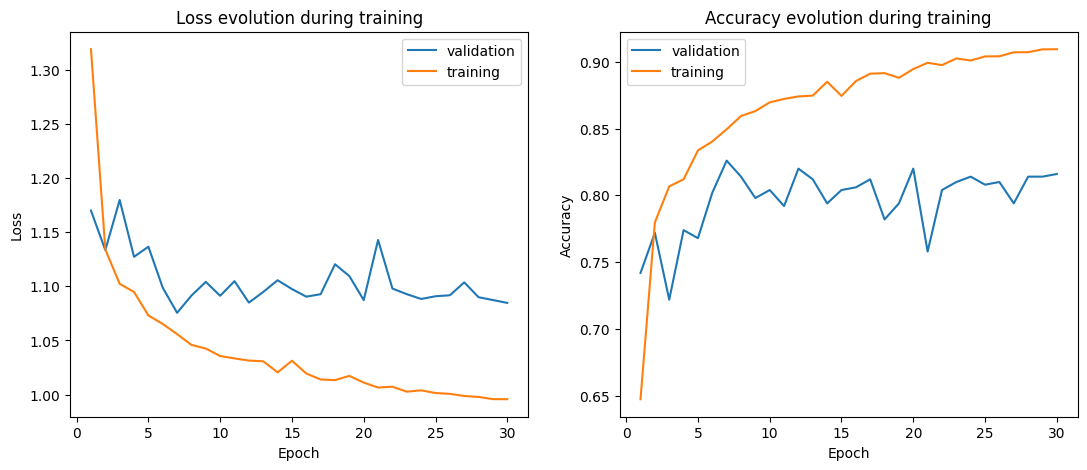

In [132]:
lr = 1e-4
dropout_p = 0.5
batch_size = 128
criterion = nn.CrossEntropyLoss()

epochs = 30# Inserte número de épocas
model =CNNModel_NR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model,
    train_dataset_2,
    val_dataset_2,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,)

show_curves(curves)

Using GPU for training
Starting training with 569 batches per epoch
Epoch 1/30
Starting epoch training...
Batch 0/569 - Loss: 1.6087, Acc: 0.1797
Batch 50/569 - Loss: 1.5880, Acc: 0.3513
Batch 100/569 - Loss: 1.5630, Acc: 0.4217
Batch 150/569 - Loss: 1.5317, Acc: 0.4722
Batch 200/569 - Loss: 1.4979, Acc: 0.5157
Batch 250/569 - Loss: 1.4630, Acc: 0.5487
Batch 300/569 - Loss: 1.4296, Acc: 0.5764
Batch 350/569 - Loss: 1.3990, Acc: 0.6004
Batch 400/569 - Loss: 1.3750, Acc: 0.6175
Batch 450/569 - Loss: 1.3526, Acc: 0.6341
Batch 500/569 - Loss: 1.3340, Acc: 0.6473
Batch 550/569 - Loss: 1.3171, Acc: 0.6592
Starting validation...
Epoch 1 completed:
  Train Loss: 1.3116, Train Acc: 0.6630
  Val Loss: 1.2131, Val Acc: 0.7020
--------------------------------------------------
Epoch 2/30
Starting epoch training...
Batch 0/569 - Loss: 1.1050, Acc: 0.8203
Batch 50/569 - Loss: 1.1345, Acc: 0.7874
Batch 100/569 - Loss: 1.1254, Acc: 0.7973
Batch 150/569 - Loss: 1.1244, Acc: 0.7966
Batch 200/569 - Loss:

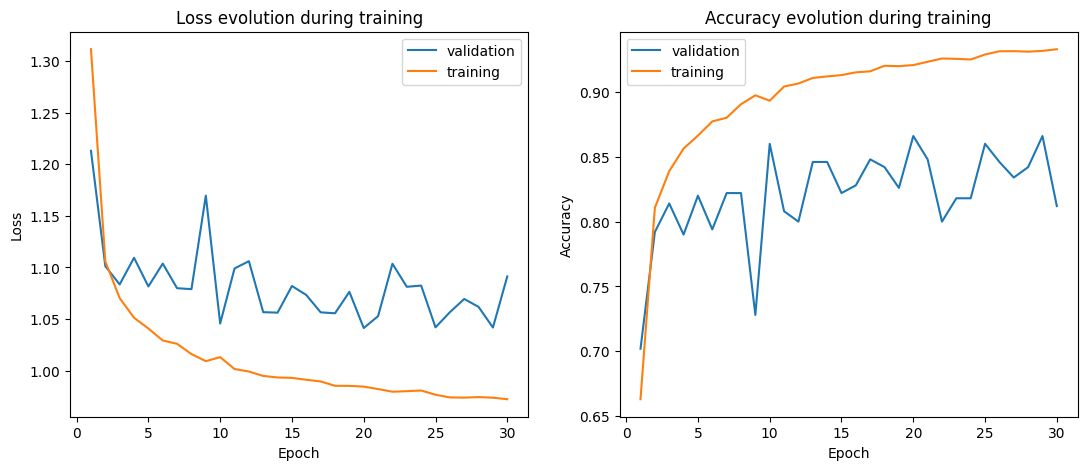

In [131]:
lr = 1e-4
dropout_p = 0.5
batch_size = 128
criterion = nn.CrossEntropyLoss()

epochs = 30# Inserte número de épocas
model =CNNModel_WR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model,
    train_dataset_2,
    val_dataset_2,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,)

show_curves(curves)

Using GPU for training
Starting training with 569 batches per epoch
Epoch 1/30
Starting epoch training...
Batch 0/569 - Loss: 1.6102, Acc: 0.1328
Batch 50/569 - Loss: 1.5804, Acc: 0.4684
Batch 100/569 - Loss: 1.5513, Acc: 0.5279
Batch 150/569 - Loss: 1.5151, Acc: 0.5711
Batch 200/569 - Loss: 1.4756, Acc: 0.6044
Batch 250/569 - Loss: 1.4384, Acc: 0.6279
Batch 300/569 - Loss: 1.4036, Acc: 0.6493
Batch 350/569 - Loss: 1.3741, Acc: 0.6662
Batch 400/569 - Loss: 1.3470, Acc: 0.6825
Batch 450/569 - Loss: 1.3252, Acc: 0.6946
Batch 500/569 - Loss: 1.3060, Acc: 0.7059
Batch 550/569 - Loss: 1.2884, Acc: 0.7165
Starting validation...
Epoch 1 completed:
  Train Loss: 1.2830, Train Acc: 0.7197
  Val Loss: 1.1193, Val Acc: 0.7940
--------------------------------------------------
Epoch 2/30
Starting epoch training...
Batch 0/569 - Loss: 1.1366, Acc: 0.7891
Batch 50/569 - Loss: 1.1102, Acc: 0.8246
Batch 100/569 - Loss: 1.0969, Acc: 0.8353
Batch 150/569 - Loss: 1.0919, Acc: 0.8373
Batch 200/569 - Loss:

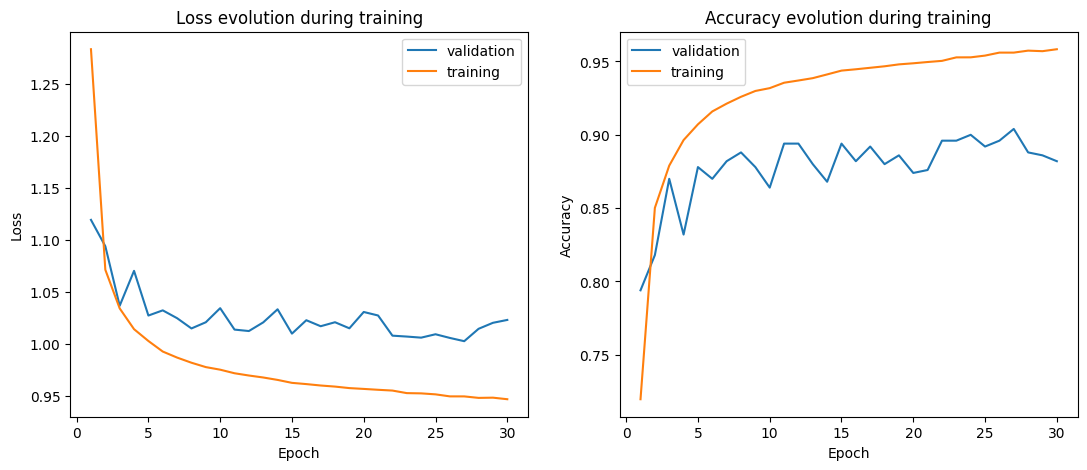

In [116]:
lr = 1e-4
dropout_p = 0.5
batch_size = 128
criterion = nn.CrossEntropyLoss()

epochs = 30# Inserte número de épocas
model =CNNModel_NR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model,
    train_dataset_1,
    val_dataset_1,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,)

show_curves(curves)

Using GPU for training
Starting training with 569 batches per epoch
Epoch 1/30
Starting epoch training...
Batch 0/569 - Loss: 1.6084, Acc: 0.2656
Batch 50/569 - Loss: 1.5840, Acc: 0.3784
Batch 100/569 - Loss: 1.5573, Acc: 0.4503
Batch 150/569 - Loss: 1.5212, Acc: 0.5026
Batch 200/569 - Loss: 1.4828, Acc: 0.5438
Batch 250/569 - Loss: 1.4429, Acc: 0.5788
Batch 300/569 - Loss: 1.4066, Acc: 0.6078
Batch 350/569 - Loss: 1.3760, Acc: 0.6306
Batch 400/569 - Loss: 1.3501, Acc: 0.6492
Batch 450/569 - Loss: 1.3273, Acc: 0.6658
Batch 500/569 - Loss: 1.3070, Acc: 0.6806
Batch 550/569 - Loss: 1.2896, Acc: 0.6931
Starting validation...
Epoch 1 completed:
  Train Loss: 1.2838, Train Acc: 0.6971
  Val Loss: 1.1086, Val Acc: 0.8220
--------------------------------------------------
Epoch 2/30
Starting epoch training...
Batch 0/569 - Loss: 1.1730, Acc: 0.7500
Batch 50/569 - Loss: 1.1008, Acc: 0.8294
Batch 100/569 - Loss: 1.0953, Acc: 0.8315
Batch 150/569 - Loss: 1.0901, Acc: 0.8365
Batch 200/569 - Loss:

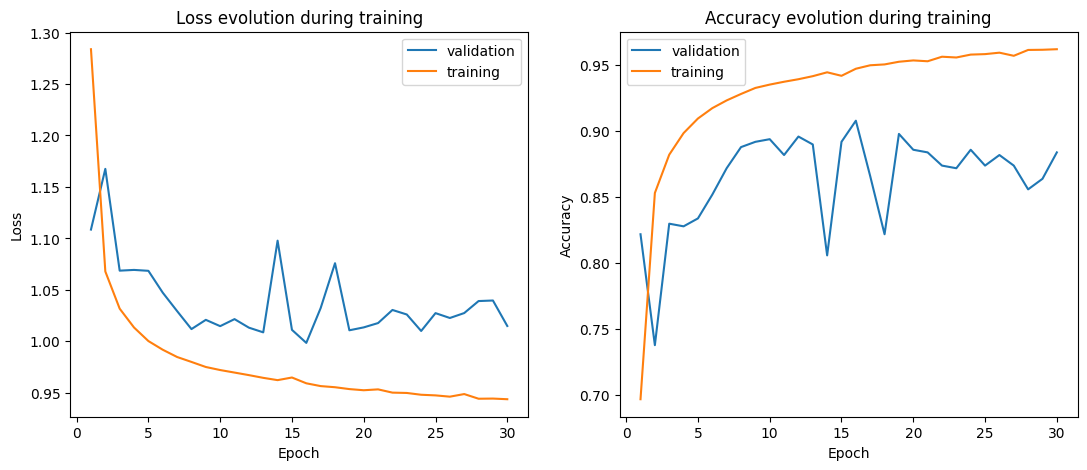

In [112]:
lr = 1e-4
dropout_p = 0.5
batch_size = 128
criterion = nn.CrossEntropyLoss()

epochs = 30# Inserte número de épocas
model =CNNModel_WR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model,
    train_dataset_1,
    val_dataset_1,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,)

show_curves(curves)

## Prueba 2 Cambio de hiperparametros, sin earlystopping y manteniendo dropout en validación

Sin rotaciones

Using GPU for training
Starting training with 1137 batches per epoch
Epoch 1/50
Starting epoch training...
Batch 0/1137 - Loss: 1.6092, Acc: 0.1875
Batch 50/1137 - Loss: 1.5241, Acc: 0.4167
Batch 100/1137 - Loss: 1.4242, Acc: 0.5365
Batch 150/1137 - Loss: 1.3524, Acc: 0.6023
Batch 200/1137 - Loss: 1.2996, Acc: 0.6503
Batch 250/1137 - Loss: 1.2620, Acc: 0.6828
Batch 300/1137 - Loss: 1.2362, Acc: 0.7046
Batch 350/1137 - Loss: 1.2142, Acc: 0.7234
Batch 400/1137 - Loss: 1.1968, Acc: 0.7377
Batch 450/1137 - Loss: 1.1813, Acc: 0.7517
Batch 500/1137 - Loss: 1.1689, Acc: 0.7620
Batch 550/1137 - Loss: 1.1587, Acc: 0.7706
Batch 600/1137 - Loss: 1.1498, Acc: 0.7779
Batch 650/1137 - Loss: 1.1420, Acc: 0.7844
Batch 700/1137 - Loss: 1.1355, Acc: 0.7895
Batch 750/1137 - Loss: 1.1291, Acc: 0.7950
Batch 800/1137 - Loss: 1.1236, Acc: 0.7997
Batch 850/1137 - Loss: 1.1181, Acc: 0.8044
Batch 900/1137 - Loss: 1.1134, Acc: 0.8083
Batch 950/1137 - Loss: 1.1094, Acc: 0.8117
Batch 1000/1137 - Loss: 1.1057, Acc:

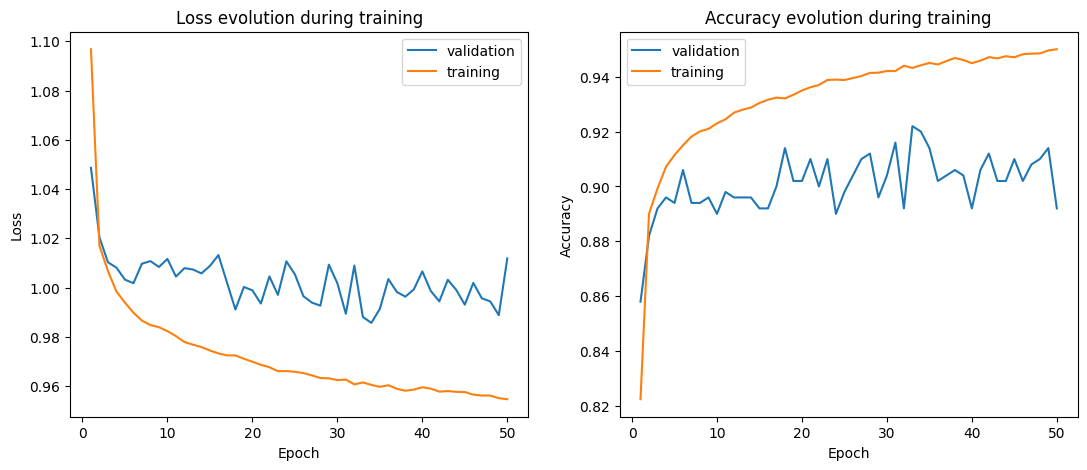

In [12]:
lr = 5e-4
dropout_p = 0.5
batch_size = 64
criterion = nn.CrossEntropyLoss()

epochs = 50# Inserte número de épocas
model =CNNModel_NR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model,
    train_dataset_1,
    val_dataset_1,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,)

show_curves(curves)

Con rotaciónes

Using GPU for training
Starting training with 1137 batches per epoch
Epoch 1/50
Starting epoch training...
Batch 0/1137 - Loss: 1.6066, Acc: 0.2500
Batch 50/1137 - Loss: 1.5368, Acc: 0.4050
Batch 100/1137 - Loss: 1.4530, Acc: 0.5127
Batch 150/1137 - Loss: 1.3716, Acc: 0.5871
Batch 200/1137 - Loss: 1.3111, Acc: 0.6417
Batch 250/1137 - Loss: 1.2713, Acc: 0.6754
Batch 300/1137 - Loss: 1.2412, Acc: 0.7009
Batch 350/1137 - Loss: 1.2174, Acc: 0.7210
Batch 400/1137 - Loss: 1.1978, Acc: 0.7380
Batch 450/1137 - Loss: 1.1822, Acc: 0.7514
Batch 500/1137 - Loss: 1.1691, Acc: 0.7623
Batch 550/1137 - Loss: 1.1579, Acc: 0.7715
Batch 600/1137 - Loss: 1.1486, Acc: 0.7793
Batch 650/1137 - Loss: 1.1406, Acc: 0.7860
Batch 700/1137 - Loss: 1.1327, Acc: 0.7926
Batch 750/1137 - Loss: 1.1264, Acc: 0.7980
Batch 800/1137 - Loss: 1.1210, Acc: 0.8023
Batch 850/1137 - Loss: 1.1161, Acc: 0.8062
Batch 900/1137 - Loss: 1.1116, Acc: 0.8099
Batch 950/1137 - Loss: 1.1075, Acc: 0.8131
Batch 1000/1137 - Loss: 1.1033, Acc:

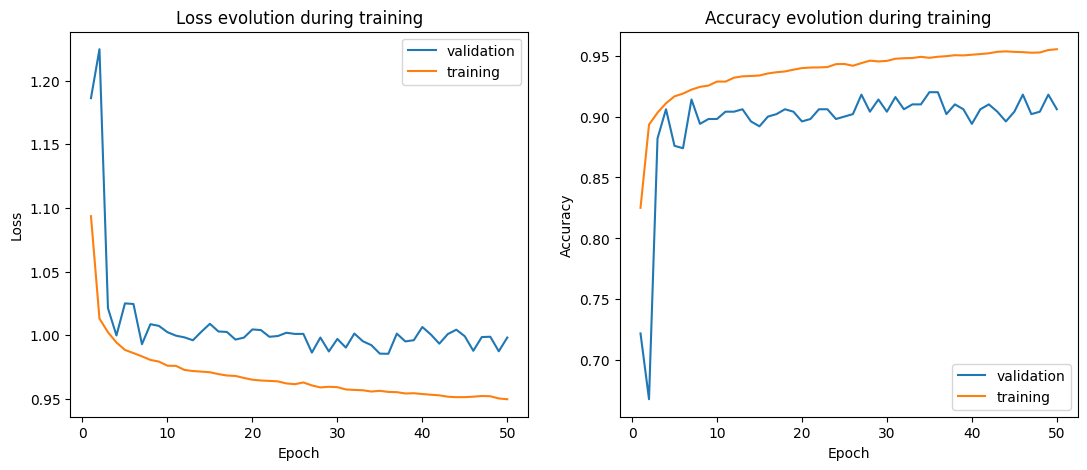

In [11]:
lr = 5e-4
dropout_p = 0.5
batch_size = 64
criterion = nn.CrossEntropyLoss()

epochs = 50# Inserte número de épocas
model =CNNModel_WR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model,
    train_dataset_1,
    val_dataset_1,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,)

show_curves(curves)

<Figure size 600x500 with 0 Axes>

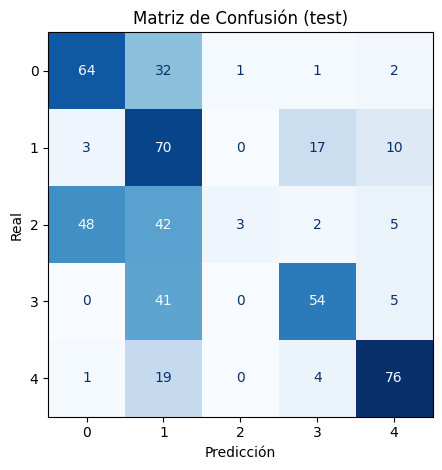

<Figure size 600x500 with 0 Axes>

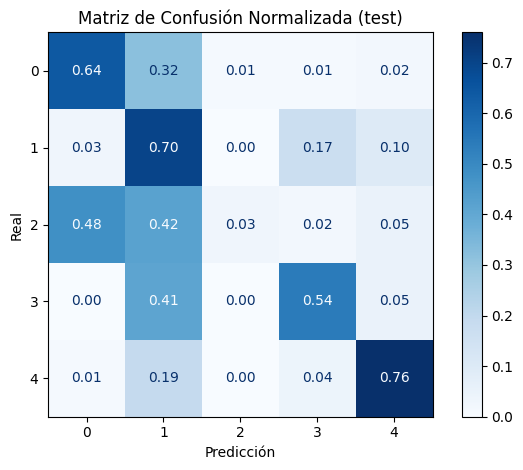

              precision    recall  f1-score   support

           0       0.55      0.64      0.59       100
           1       0.34      0.70      0.46       100
           2       0.75      0.03      0.06       100
           3       0.69      0.54      0.61       100
           4       0.78      0.76      0.77       100

    accuracy                           0.53       500
   macro avg       0.62      0.53      0.50       500
weighted avg       0.62      0.53      0.50       500



In [16]:
# 1) Loader de validación (ajusta batch_size si quieres)
test_loader = DataLoader(test_dataset_1, batch_size=256, shuffle=False)

# 2) Eval mode + device
model.eval()
device = next(model.parameters()).device  # detecta CPU/CUDA

y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        # 1) Extraer x (inputs) y y (labels) sin importar el formato
        if isinstance(batch, (list, tuple)):
            # Acepta (x, y) o (x, y, algo_mas, ...)
            x_test, y_test = batch[0], batch[1]
        elif isinstance(batch, dict):
            # Intenta claves comunes; si no, toma las dos primeras
            key_x = next((k for k in ("x","X","input","inputs","image","images","data") if k in batch), None)
            key_y = next((k for k in ("y","Y","target","targets","label","labels") if k in batch), None)
            if key_x is None or key_y is None:
                # fallback: primeras dos claves
                keys = list(batch.keys())
                key_x, key_y = keys[0], keys[1]
            x_test, y_test = batch[key_x], batch[key_y]
        else:
            raise TypeError(f"Formato de batch no soportado: {type(batch)}")

        # 2) Enviar a device
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        # 3) Forward y predicción
        logits = model(x_test)
        pred = torch.argmax(logits, dim=1)

        # 4) Si y_val viene one-hot, convertir a índices
        if y_test.ndim > 1 and y_test.size(-1) > 1:
            y_test = torch.argmax(y_test, dim=1)

        y_true.append(y_test.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# 3) Etiquetas ordenadas (por si no son 0..C-1)
labels_sorted = np.unique(np.concatenate([y_true, y_pred]))

# 4) Matriz de confusión (cruda)
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title("Matriz de Confusión (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 5) Matriz de confusión normalizada por fila (recall por clase)
cm_norm = confusion_matrix(y_true, y_pred, labels=labels_sorted, normalize='true')

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels_sorted)
disp.plot(values_format='.2f', cmap='Blues', colorbar=True)
plt.title("Matriz de Confusión Normalizada (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 6) Classification report (precision / recall / f1 por clase)
print(classification_report(y_true, y_pred, labels=labels_sorted))

# Prueba 3 Ajustando validacion sin droput en validación Y sin early stopping

Con rotaciones

Using GPU for training
Starting training with 1137 batches per epoch
Epoch 1/50
Starting epoch training...
Batch 0/1137 - Loss: 1.6113, Acc: 0.1562
Batch 50/1137 - Loss: 1.5091, Acc: 0.4418
Batch 100/1137 - Loss: 1.4084, Acc: 0.5532
Batch 150/1137 - Loss: 1.3332, Acc: 0.6212
Batch 200/1137 - Loss: 1.2823, Acc: 0.6658
Batch 250/1137 - Loss: 1.2456, Acc: 0.6980
Batch 300/1137 - Loss: 1.2183, Acc: 0.7210
Batch 350/1137 - Loss: 1.1970, Acc: 0.7392
Batch 400/1137 - Loss: 1.1803, Acc: 0.7532
Batch 450/1137 - Loss: 1.1679, Acc: 0.7631
Batch 500/1137 - Loss: 1.1564, Acc: 0.7726
Batch 550/1137 - Loss: 1.1462, Acc: 0.7815
Batch 600/1137 - Loss: 1.1382, Acc: 0.7882
Batch 650/1137 - Loss: 1.1309, Acc: 0.7947
Batch 700/1137 - Loss: 1.1241, Acc: 0.8003
Batch 750/1137 - Loss: 1.1178, Acc: 0.8058
Batch 800/1137 - Loss: 1.1125, Acc: 0.8103
Batch 850/1137 - Loss: 1.1076, Acc: 0.8143
Batch 900/1137 - Loss: 1.1028, Acc: 0.8186
Batch 950/1137 - Loss: 1.0989, Acc: 0.8216
Batch 1000/1137 - Loss: 1.0953, Acc:

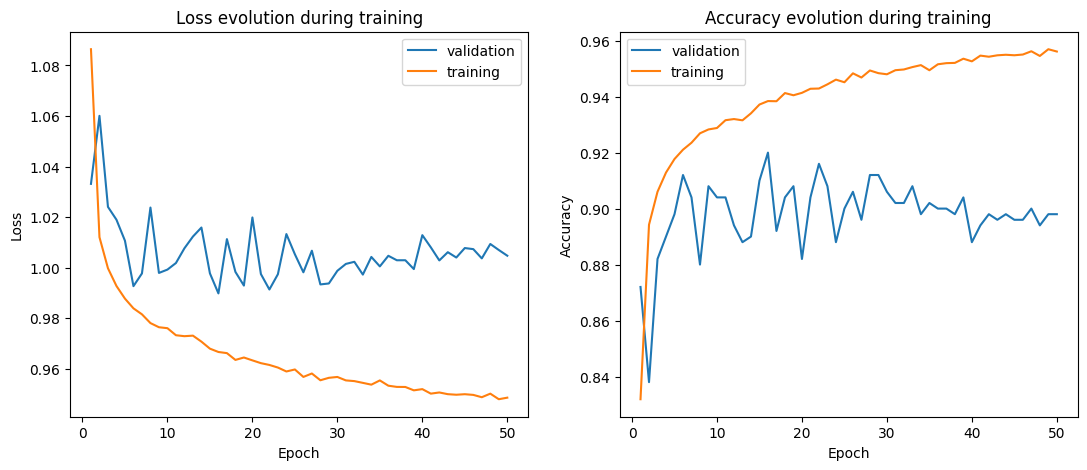

In [22]:
lr = 5e-4
dropout_p = 0.5
batch_size = 64
criterion = nn.CrossEntropyLoss()

epochs = 50# Inserte número de épocas
model_new_WR =CNNModel_WR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model_new_WR,
    train_dataset_1,
    val_dataset_1,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,)

show_curves(curves)

<Figure size 600x500 with 0 Axes>

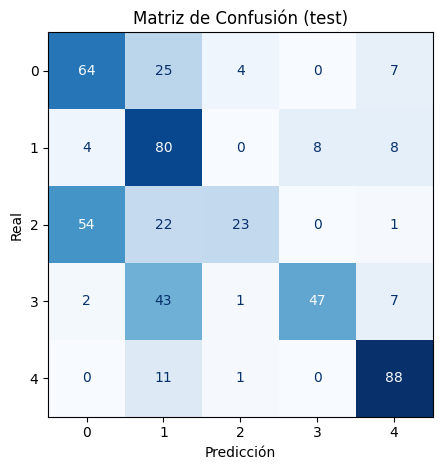

<Figure size 600x500 with 0 Axes>

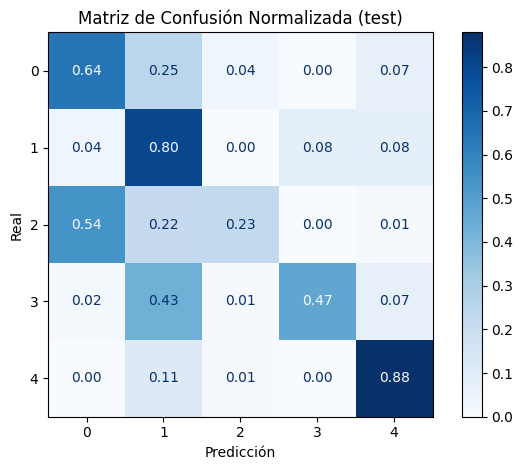

              precision    recall  f1-score   support

           0       0.52      0.64      0.57       100
           1       0.44      0.80      0.57       100
           2       0.79      0.23      0.36       100
           3       0.85      0.47      0.61       100
           4       0.79      0.88      0.83       100

    accuracy                           0.60       500
   macro avg       0.68      0.60      0.59       500
weighted avg       0.68      0.60      0.59       500



In [24]:
# 1) Loader de validación (ajusta batch_size si quieres)
test_loader = DataLoader(test_dataset_1, batch_size=256, shuffle=False)

# 2) Eval mode + device
model_new_WR.eval()
device = next(model_new_WR.parameters()).device  # detecta CPU/CUDA

y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        # 1) Extraer x (inputs) y y (labels) sin importar el formato
        if isinstance(batch, (list, tuple)):
            # Acepta (x, y) o (x, y, algo_mas, ...)
            x_test, y_test = batch[0], batch[1]
        elif isinstance(batch, dict):
            # Intenta claves comunes; si no, toma las dos primeras
            key_x = next((k for k in ("x","X","input","inputs","image","images","data") if k in batch), None)
            key_y = next((k for k in ("y","Y","target","targets","label","labels") if k in batch), None)
            if key_x is None or key_y is None:
                # fallback: primeras dos claves
                keys = list(batch.keys())
                key_x, key_y = keys[0], keys[1]
            x_test, y_test = batch[key_x], batch[key_y]
        else:
            raise TypeError(f"Formato de batch no soportado: {type(batch)}")

        # 2) Enviar a device
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        # 3) Forward y predicción
        logits = model_new_WR(x_test)
        pred = torch.argmax(logits, dim=1)

        # 4) Si y_val viene one-hot, convertir a índices
        if y_test.ndim > 1 and y_test.size(-1) > 1:
            y_test = torch.argmax(y_test, dim=1)

        y_true.append(y_test.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# 3) Etiquetas ordenadas (por si no son 0..C-1)
labels_sorted = np.unique(np.concatenate([y_true, y_pred]))

# 4) Matriz de confusión (cruda)
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title("Matriz de Confusión (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 5) Matriz de confusión normalizada por fila (recall por clase)
cm_norm = confusion_matrix(y_true, y_pred, labels=labels_sorted, normalize='true')

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels_sorted)
disp.plot(values_format='.2f', cmap='Blues', colorbar=True)
plt.title("Matriz de Confusión Normalizada (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 6) Classification report (precision / recall / f1 por clase)
print(classification_report(y_true, y_pred, labels=labels_sorted))

## Prueba 4 sin dropout en validación y con earlystopping

Con rotaciones

Using GPU for training
Starting training with 1137 batches per epoch
Epoch 1/50
Starting epoch training...
Batch 0/1137 - Loss: 1.6066, Acc: 0.2500
Batch 50/1137 - Loss: 1.5145, Acc: 0.4914
Batch 100/1137 - Loss: 1.4167, Acc: 0.5569
Batch 150/1137 - Loss: 1.3470, Acc: 0.6158
Batch 200/1137 - Loss: 1.2938, Acc: 0.6608
Batch 250/1137 - Loss: 1.2562, Acc: 0.6919
Batch 300/1137 - Loss: 1.2292, Acc: 0.7145
Batch 350/1137 - Loss: 1.2065, Acc: 0.7333
Batch 400/1137 - Loss: 1.1887, Acc: 0.7479
Batch 450/1137 - Loss: 1.1751, Acc: 0.7590
Batch 500/1137 - Loss: 1.1627, Acc: 0.7693
Batch 550/1137 - Loss: 1.1524, Acc: 0.7776
Batch 600/1137 - Loss: 1.1436, Acc: 0.7848
Batch 650/1137 - Loss: 1.1359, Acc: 0.7911
Batch 700/1137 - Loss: 1.1284, Acc: 0.7974
Batch 750/1137 - Loss: 1.1221, Acc: 0.8026
Batch 800/1137 - Loss: 1.1165, Acc: 0.8072
Batch 850/1137 - Loss: 1.1119, Acc: 0.8108
Batch 900/1137 - Loss: 1.1070, Acc: 0.8148
Batch 950/1137 - Loss: 1.1028, Acc: 0.8182
Batch 1000/1137 - Loss: 1.0993, Acc:

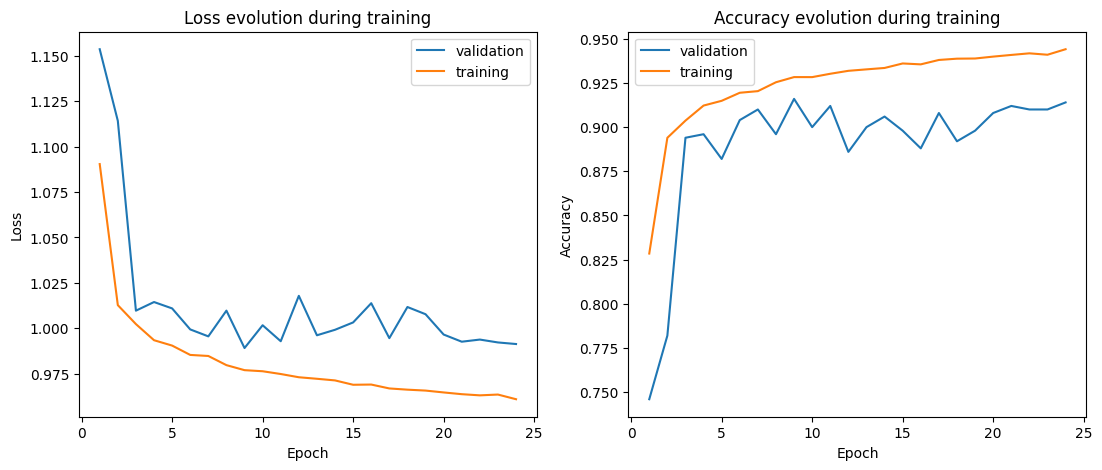

In [ ]:
lr = 5e-4
dropout_p = 0.5
batch_size = 64
criterion = nn.CrossEntropyLoss()

epochs = 50# Inserte número de épocas
model_new_WR_2 =CNNModel_WR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model_new_WR_2,
    train_dataset_1,
    val_dataset_1,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
    early_stopping_tolerance=15
    )

show_curves(curves)

<Figure size 600x500 with 0 Axes>

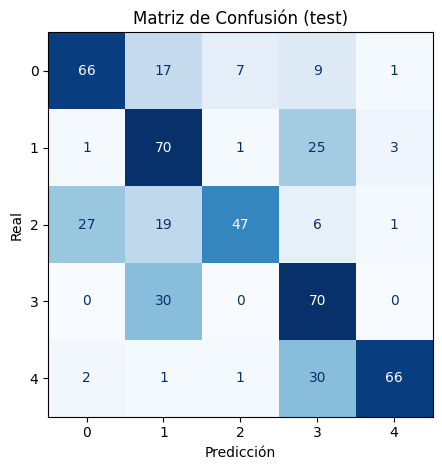

<Figure size 600x500 with 0 Axes>

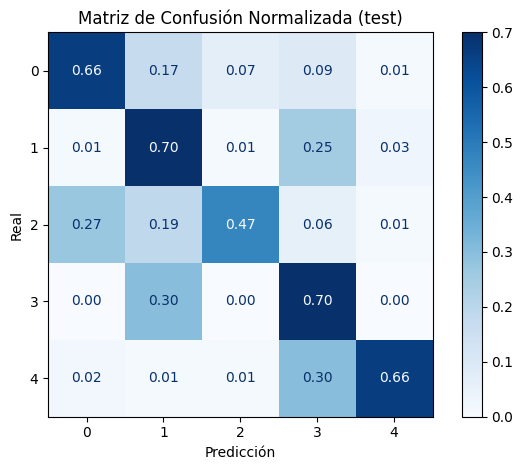

              precision    recall  f1-score   support

           0       0.69      0.66      0.67       100
           1       0.51      0.70      0.59       100
           2       0.84      0.47      0.60       100
           3       0.50      0.70      0.58       100
           4       0.93      0.66      0.77       100

    accuracy                           0.64       500
   macro avg       0.69      0.64      0.64       500
weighted avg       0.69      0.64      0.64       500



In [30]:
# 1) Loader de validación (ajusta batch_size si quieres)
test_loader = DataLoader(test_dataset_1, batch_size=256, shuffle=False)

# 2) Eval mode + device
model_new_WR_2.eval()
device = next(model_new_WR_2.parameters()).device  # detecta CPU/CUDA

y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        # 1) Extraer x (inputs) y y (labels) sin importar el formato
        if isinstance(batch, (list, tuple)):
            # Acepta (x, y) o (x, y, algo_mas, ...)
            x_test, y_test = batch[0], batch[1]
        elif isinstance(batch, dict):
            # Intenta claves comunes; si no, toma las dos primeras
            key_x = next((k for k in ("x","X","input","inputs","image","images","data") if k in batch), None)
            key_y = next((k for k in ("y","Y","target","targets","label","labels") if k in batch), None)
            if key_x is None or key_y is None:
                # fallback: primeras dos claves
                keys = list(batch.keys())
                key_x, key_y = keys[0], keys[1]
            x_test, y_test = batch[key_x], batch[key_y]
        else:
            raise TypeError(f"Formato de batch no soportado: {type(batch)}")

        # 2) Enviar a device
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        # 3) Forward y predicción
        logits = model_new_WR_2(x_test)
        pred = torch.argmax(logits, dim=1)

        # 4) Si y_val viene one-hot, convertir a índices
        if y_test.ndim > 1 and y_test.size(-1) > 1:
            y_test = torch.argmax(y_test, dim=1)

        y_true.append(y_test.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# 3) Etiquetas ordenadas (por si no son 0..C-1)
labels_sorted = np.unique(np.concatenate([y_true, y_pred]))

# 4) Matriz de confusión (cruda)
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title("Matriz de Confusión (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 5) Matriz de confusión normalizada por fila (recall por clase)
cm_norm = confusion_matrix(y_true, y_pred, labels=labels_sorted, normalize='true')

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels_sorted)
disp.plot(values_format='.2f', cmap='Blues', colorbar=True)
plt.title("Matriz de Confusión Normalizada (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 6) Classification report (precision / recall / f1 por clase)
print(classification_report(y_true, y_pred, labels=labels_sorted))

Sin rotaciones

Using GPU for training
Starting training with 1137 batches per epoch
Epoch 1/50
Starting epoch training...
Batch 0/1137 - Loss: 1.6126, Acc: 0.1719
Batch 50/1137 - Loss: 1.5032, Acc: 0.4694
Batch 100/1137 - Loss: 1.3997, Acc: 0.5750
Batch 150/1137 - Loss: 1.3240, Acc: 0.6393
Batch 200/1137 - Loss: 1.2760, Acc: 0.6793
Batch 250/1137 - Loss: 1.2418, Acc: 0.7064
Batch 300/1137 - Loss: 1.2165, Acc: 0.7269
Batch 350/1137 - Loss: 1.1970, Acc: 0.7423
Batch 400/1137 - Loss: 1.1828, Acc: 0.7532
Batch 450/1137 - Loss: 1.1722, Acc: 0.7612
Batch 500/1137 - Loss: 1.1608, Acc: 0.7706
Batch 550/1137 - Loss: 1.1517, Acc: 0.7781
Batch 600/1137 - Loss: 1.1434, Acc: 0.7851
Batch 650/1137 - Loss: 1.1361, Acc: 0.7911
Batch 700/1137 - Loss: 1.1302, Acc: 0.7958
Batch 750/1137 - Loss: 1.1241, Acc: 0.8009
Batch 800/1137 - Loss: 1.1184, Acc: 0.8056
Batch 850/1137 - Loss: 1.1133, Acc: 0.8097
Batch 900/1137 - Loss: 1.1096, Acc: 0.8128
Batch 950/1137 - Loss: 1.1058, Acc: 0.8158
Batch 1000/1137 - Loss: 1.1022, Acc:

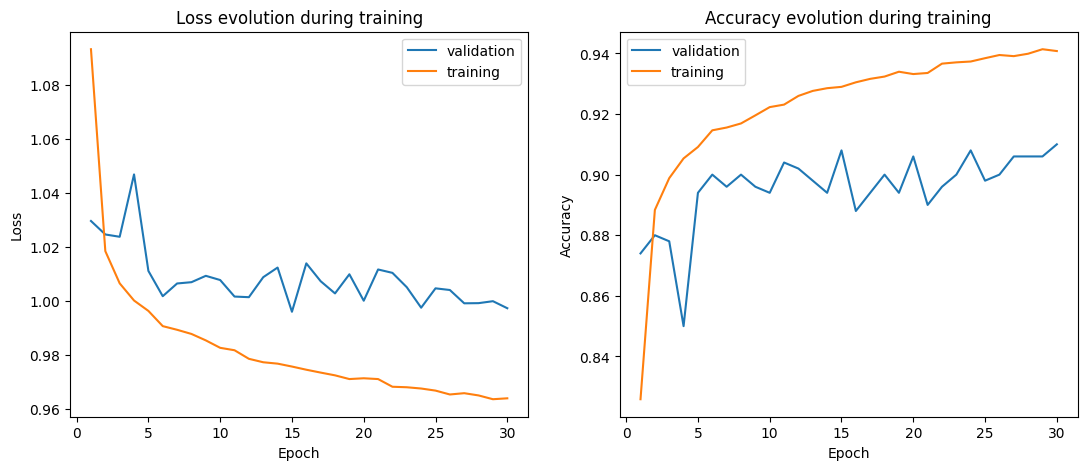

In [32]:
lr = 5e-4
dropout_p = 0.5
batch_size = 64
criterion = nn.CrossEntropyLoss()

epochs = 50# Inserte número de épocas
model_new_NR =CNNModel_NR(dropout_p=dropout_p) # Inserte modelo a entrenar

curves = train_model_fixed(
    model_new_NR,
    train_dataset_1,
    val_dataset_1,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
    early_stopping_tolerance=15
    )

show_curves(curves)

<Figure size 600x500 with 0 Axes>

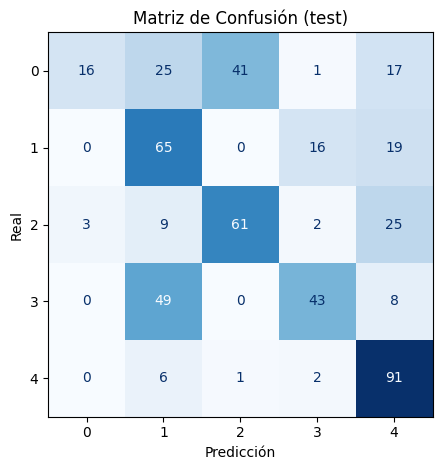

<Figure size 600x500 with 0 Axes>

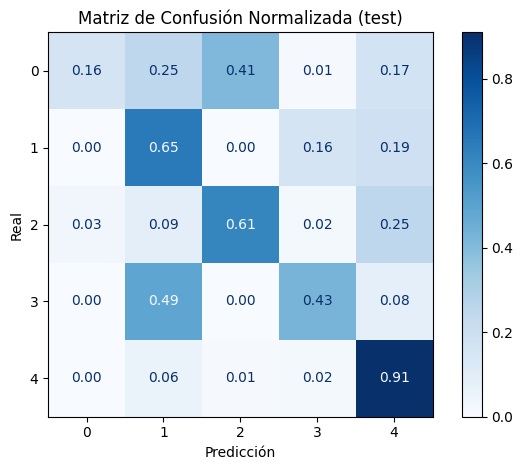

              precision    recall  f1-score   support

           0       0.84      0.16      0.27       100
           1       0.42      0.65      0.51       100
           2       0.59      0.61      0.60       100
           3       0.67      0.43      0.52       100
           4       0.57      0.91      0.70       100

    accuracy                           0.55       500
   macro avg       0.62      0.55      0.52       500
weighted avg       0.62      0.55      0.52       500



In [33]:
# 1) Loader de validación (ajusta batch_size si quieres)
test_loader = DataLoader(test_dataset_1, batch_size=256, shuffle=False)

# 2) Eval mode + device
model_new_NR.eval()
device = next(model_new_NR.parameters()).device  # detecta CPU/CUDA

y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        # 1) Extraer x (inputs) y y (labels) sin importar el formato
        if isinstance(batch, (list, tuple)):
            # Acepta (x, y) o (x, y, algo_mas, ...)
            x_test, y_test = batch[0], batch[1]
        elif isinstance(batch, dict):
            # Intenta claves comunes; si no, toma las dos primeras
            key_x = next((k for k in ("x","X","input","inputs","image","images","data") if k in batch), None)
            key_y = next((k for k in ("y","Y","target","targets","label","labels") if k in batch), None)
            if key_x is None or key_y is None:
                # fallback: primeras dos claves
                keys = list(batch.keys())
                key_x, key_y = keys[0], keys[1]
            x_test, y_test = batch[key_x], batch[key_y]
        else:
            raise TypeError(f"Formato de batch no soportado: {type(batch)}")

        # 2) Enviar a device
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        # 3) Forward y predicción
        logits = model_new_NR(x_test)
        pred = torch.argmax(logits, dim=1)

        # 4) Si y_val viene one-hot, convertir a índices
        if y_test.ndim > 1 and y_test.size(-1) > 1:
            y_test = torch.argmax(y_test, dim=1)

        y_true.append(y_test.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# 3) Etiquetas ordenadas (por si no son 0..C-1)
labels_sorted = np.unique(np.concatenate([y_true, y_pred]))

# 4) Matriz de confusión (cruda)
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title("Matriz de Confusión (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 5) Matriz de confusión normalizada por fila (recall por clase)
cm_norm = confusion_matrix(y_true, y_pred, labels=labels_sorted, normalize='true')

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels_sorted)
disp.plot(values_format='.2f', cmap='Blues', colorbar=True)
plt.title("Matriz de Confusión Normalizada (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 6) Classification report (precision / recall / f1 por clase)
print(classification_report(y_true, y_pred, labels=labels_sorted))